In [6]:
#Tuve que buscar ayuda externar para esto pero funciona entonces, good.
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [2]:
limx = [-20, 20]
limy = [-20, 20]
WORK_SPACE_LIMIT = [-20, 20]

GOAL_SAMPLE_RATE = 0.05
STEP_SIZE = 1.0 

class Obstaculo():
    def __init__(self, limxMax, limxMin, limyMax, limyMin):
        self.limites = [limxMax, limxMin, limyMax, limyMin]

    def in_collision(self, x, y):
        if self.limites[0] >= x >= self.limites[1] and self.limites[2] >= y >= self.limites[3]:
            return True
        return False

class Obstaculo_circulo():
    def __init__(self, centerx, centery, radius):
        self.center = [centerx, centery]
        self.radius = radius
    
    def in_collision(self, x, y):
        d = np.sqrt((x - self.center[0])**2 + (y - self.center[1])**2)
        if d <= self.radius:
            return True
        return False

In [3]:
class RRTNode():
    def __init__(self, pos=[0,0], papa=None):
        self.pos = np.array(pos, dtype=float)
        self.papa = papa
        self.children = []

    def __repr__(self):
        return str(f"x:{self.pos[0]:.2f},y:{self.pos[1]:.2f}")

    def distance_to(self, other_pos):
        return np.linalg.norm(self.pos - other_pos)

    def to_list(self):
        list_of_nodes = [self]
        for h in self.children:
            list_of_nodes.extend(h.to_list())
        return list_of_nodes

def check_collision_segment(start_pos, end_pos, obstaculos, step=0.5):
    """Verifica si el segmento entre start_pos y end_pos colisiona con algún obstáculo."""
    dist = np.linalg.norm(end_pos - start_pos)
    num_steps = math.ceil(dist / step)
    
    for i in range(num_steps + 1):
        t = i * step / dist if dist > 0 else 0
        if t > 1: t = 1
        
        check_pos = start_pos + t * (end_pos - start_pos)
        
        for ob in obstaculos:
            if ob.in_collision(check_pos[0], check_pos[1]):
                return True
    return False 

def nearest_node(tree_nodes, random_pos):
    min_dist = float('inf')
    closest_node = None
    for node in tree_nodes:
        dist = node.distance_to(random_pos)
        if dist < min_dist:
            min_dist = dist
            closest_node = node
    return closest_node

def steer(from_node, to_pos, step_size):
    direction = to_pos - from_node.pos
    dist = np.linalg.norm(direction)
    
    if dist < step_size:
        return RRTNode(pos=to_pos, papa=from_node)
    else:
        new_pos = from_node.pos + (direction / dist) * step_size
        return RRTNode(pos=new_pos, papa=from_node)

def reconstruct_path(node):
    path = []
    current = node
    while current:
        path.append(current)
        current = current.papa
    return path[::-1]


def RRT_search(start_pos, goal_pos, obstaculos, max_iterations=2000, step_size=STEP_SIZE):
    
    start_node = RRTNode(pos=start_pos)
    goal_pos = np.array(goal_pos, dtype=float)
    nodes = [start_node]
    
    for _ in range(max_iterations):

        if random.random() < GOAL_SAMPLE_RATE:
            rand_pos = goal_pos
        else:
            rand_pos = np.array([
                random.uniform(WORK_SPACE_LIMIT[0], WORK_SPACE_LIMIT[1]),
                random.uniform(WORK_SPACE_LIMIT[0], WORK_SPACE_LIMIT[1])
            ])

        nearest = nearest_node(nodes, rand_pos)

        new_node = steer(nearest, rand_pos, step_size)

        if not check_collision_segment(nearest.pos, new_node.pos, obstaculos):

            nearest.children.append(new_node)
            nodes.append(new_node)

            if new_node.distance_to(goal_pos) < step_size * 1.5:
                 if not check_collision_segment(new_node.pos, goal_pos, obstaculos):
                    goal_node = RRTNode(pos=goal_pos, papa=new_node)
                    new_node.children.append(goal_node)
                    return reconstruct_path(goal_node), nodes
    
    return [], nodes

In [4]:
class Robot():
    def __init__(self, dof, numb=1):
        self.dof = dof
        self.model = None
        self.num_bodies = numb
        self.global_position = [0.0, 0.0]
        self.trajectory = []
        self.obstaculos = []
        self.raiz = None
        
    def add_obstacle(self, limxMax, limxMin ,limyMax, limyMin):
        self.obstaculos.append(Obstaculo(limxMax, limxMin ,limyMax, limyMin))
        
    def add_circle_obstacle(self, centerx, centery,rad):
        self.obstaculos.append(Obstaculo_circulo(centerx, centery, rad))

    def draw_obstacles(self, canvas):
        for obs in self.obstaculos:
            if isinstance(obs, Obstaculo_circulo):
                obscirc= plt.Circle(obs.center, obs.radius, fill=False)
                canvas.add_artist(obscirc)
            else:
                canvas.plot(
                    [obs.limites[1], obs.limites[0], obs.limites[0], obs.limites[1], obs.limites[1]],
                    [obs.limites[3], obs.limites[3], obs.limites[2], obs.limites[2], obs.limites[3]],
                    color = 'red'
                )
                
    def draw_generated_nodes(self, canvas):
        if self.raiz is not None:
            for nodo in self.generated_nodes:
                if nodo.papa:
                     canvas.plot([nodo.pos[0], nodo.papa.pos[0]], 
                                 [nodo.pos[1], nodo.papa.pos[1]], 
                                 color='blue', 
                                 marker='.', 
                                 markersize=1)
        else:
            print("Calcular la Trayectoria primero")
    
    def draw_trajectory (self, canvas):
        lasx = []
        lasy = []
        
        for estado in self.trajectory:
            x, y = estado.pos
            lasx.append(x)
            lasy.append(y)
            
        if lasx:
            canvas.plot(lasx, lasy, color='black', linewidth=2, marker='o', markersize=3)
            canvas.scatter(x=lasx[0], y=lasy[0], marker="^", color="yellow", s=100)
            canvas.scatter(x=lasx[-1], y=lasy[-1], marker="s", color="green", s=100)
        
    def plot_all(self):
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xlim(-20,20)
        ax.set_ylim(-20,20)
        
        ax.plot(
            [limx[0], limx[1], limx[1], limx[0], limx[0]],
            [limy[1], limy[1], limy[0], limy[0], limy[1]],
            color = 'purple'
        )
        
        ax.set_aspect(1)
        self.draw_generated_nodes(ax)
        self.draw_trajectory(ax)
        self.draw_obstacles(ax)
        ax.set_title("RRT Path Planning")
        plt.show()
        
    def busca_camino_goal(self, goalpos, search_mode="RRT"):
        if search_mode == "RRT":
            self.trajectory, self.generated_nodes = RRT_search(self.global_position, goalpos, self.obstaculos)
            self.raiz = self.generated_nodes[0] if self.generated_nodes else None
            
            if not self.trajectory:
                print("RRT: No se encontró un camino al objetivo en las iteraciones permitidas.")
            return self.trajectory
        else:
             print(f"El modo de búsqueda '{search_mode}' no está implementado en este contexto RRT.")
             return []

Camino encontrado con RRT (Número de Pasos): 20


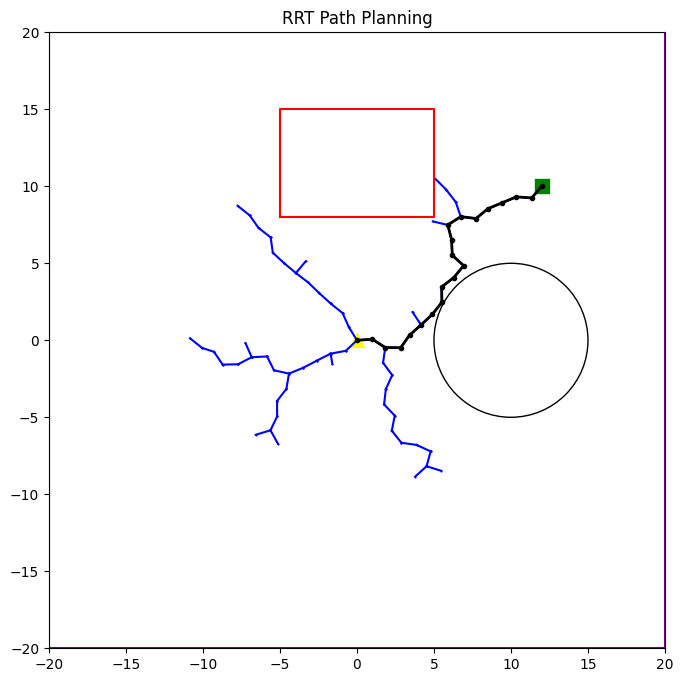

In [5]:
robot_rrt = Robot(6)
robot_rrt.global_position = [0.0, 0.0]

robot_rrt.add_obstacle(5, -5, 15, 8) 
robot_rrt.add_circle_obstacle(10, 0, 5)

goal_position = [12.0, 10.0]

trayectoria_rrt = robot_rrt.busca_camino_goal(goal_position, "RRT")

if trayectoria_rrt:
    print(f"Camino encontrado con RRT (Número de Pasos): {len(trayectoria_rrt) - 1}")
    robot_rrt.plot_all()
else:
    print("La búsqueda RRT no tuvo éxito.")